## Import Liblary

In [33]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow # path cv2.imshow di google colab

## Mempersiapkan Gambar

In [34]:
from google.colab import drive

In [35]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import os

In [37]:
directory_path = '/content/drive/My Drive/uts-ml/data/'
os.chdir(directory_path)

In [38]:
import glob

In [39]:
# Membaca semua citra dari folder
image_files = []
for img_path in glob.glob(f'{directory_path}*.jpg'):
    noise = cv2.imread(img_path)
    image_files.append(noise)

In [40]:
def reshape_data(image):
  h, w, ch= image.shape
  data = image / 255.0
  data = data.reshape(h * w, ch)
  return data

In [41]:
def plot_pixels(data, title='Input color space: 16 million possible colors', colors=None, N=10000):

  if colors is None:
      colors = data

  # choose a random subset
  rng = np.random.RandomState(0)
  i = rng.permutation(data.shape[0])[:N]
  colors = colors[i]
  R, G, B = data[i].T

  fig, ax = plt.subplots(1, 2, figsize=(8, 4))
  ax[0].scatter(R, G, color=colors, marker='.')
  ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

  ax[1].scatter(R, B, color=colors, marker='.')
  ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

  fig.suptitle(title, size=14)

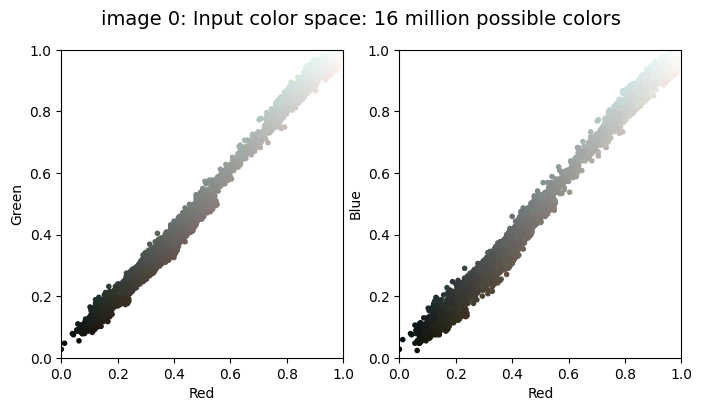

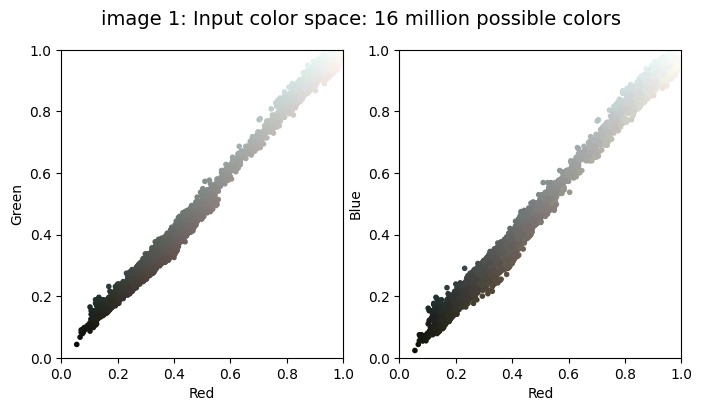

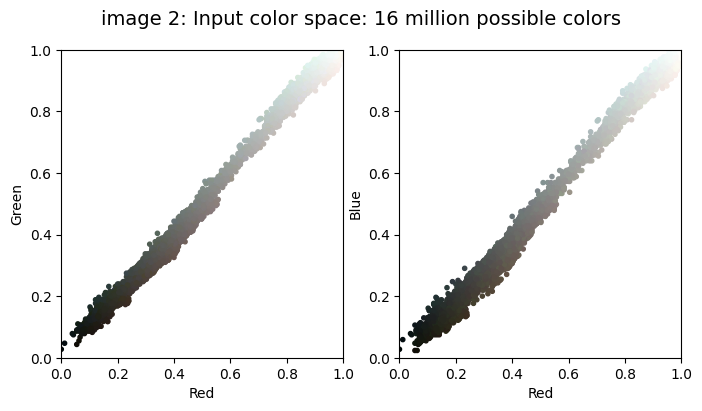

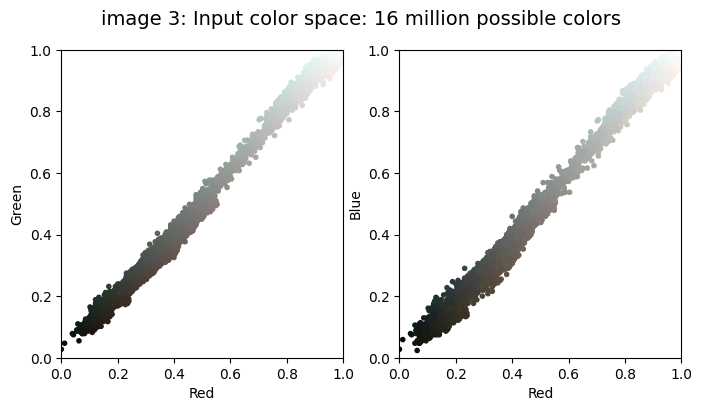

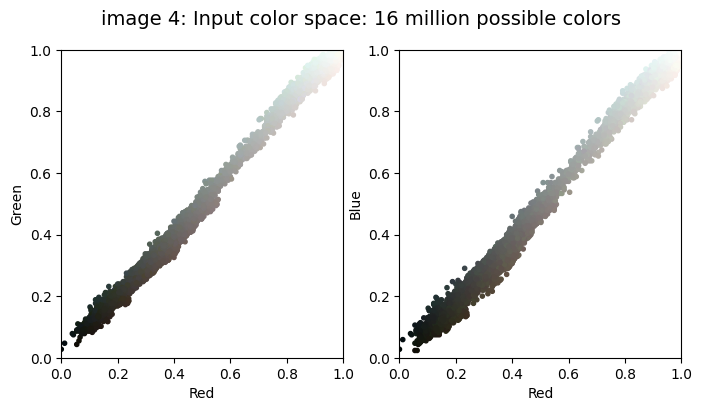

In [42]:
for i,image_file in enumerate(image_files):
  data = reshape_data(image_file)
  plot_pixels(data, title = f'image {i}: Input color space: 16 million possible colors')

##

In [43]:
def compare_image(image_1, image_2, title_1 = "Original Image", title_2 = "New Image"):
  fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
  fig.subplots_adjust(wspace=0.05)
  ax[0].imshow(image_1)
  ax[0].set_title(title_1, size=16)
  ax[1].imshow(image_2)
  ax[1].set_title(title_2, size=16);

In [44]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.
from sklearn.cluster import MiniBatchKMeans

In [45]:

def cluster_image_minibatch(image, image_data):

  kmeans = MiniBatchKMeans(2)
  kmeans.fit(image_data)
  new_colors = kmeans.cluster_centers_[kmeans.predict(data)]
  recolored = new_colors.reshape(image.shape)

  return (recolored)

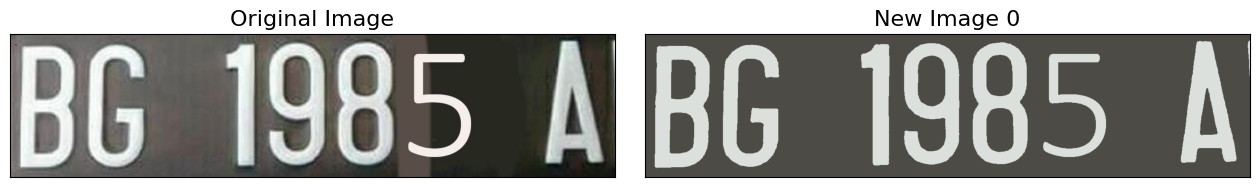

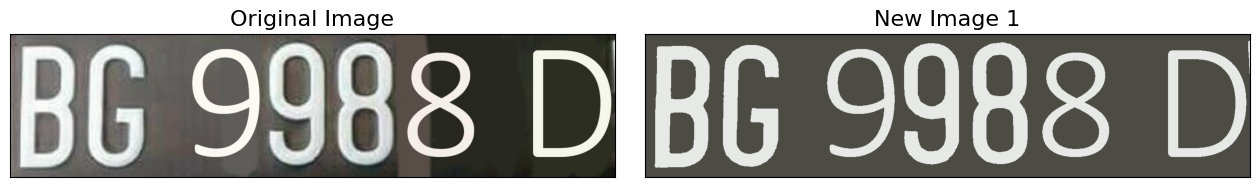

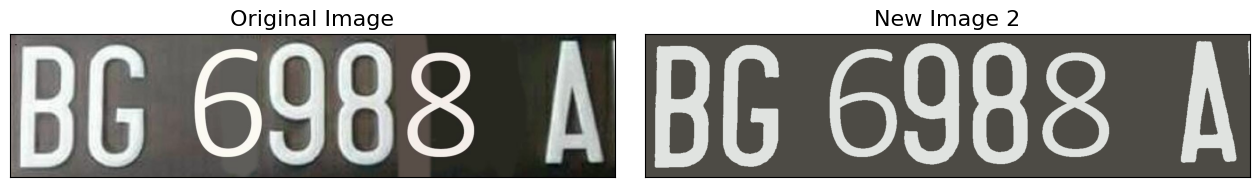

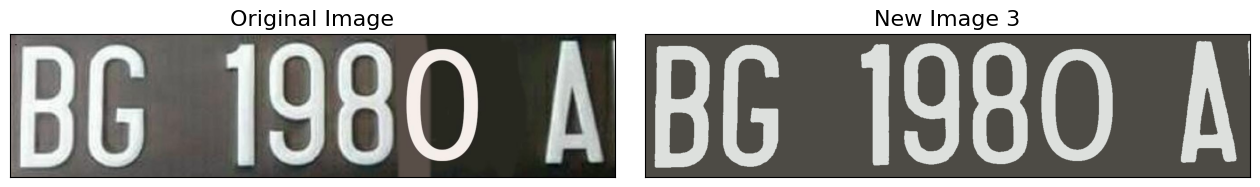

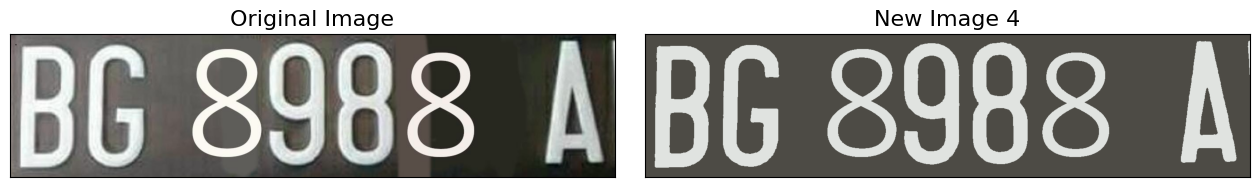

In [46]:
for i,image_file in enumerate(image_files):
  data = reshape_data(image_file)
  recolored = cluster_image_minibatch(image_file,data)
  compare_image(image_file, recolored, title_2 = f"New Image {i}")


## Cara Kedua

In [47]:
from sklearn.cluster import KMeans

In [48]:
def cluster_image_kmeans(image):
  X = image.reshape(-1,3)
  kmeans = KMeans(n_clusters = 2, n_init=10)

  kmeans.fit(data)
  segmented_image = kmeans.cluster_centers_[kmeans.labels_]
  segmented_image = segmented_image.reshape(image.shape)

  return segmented_image

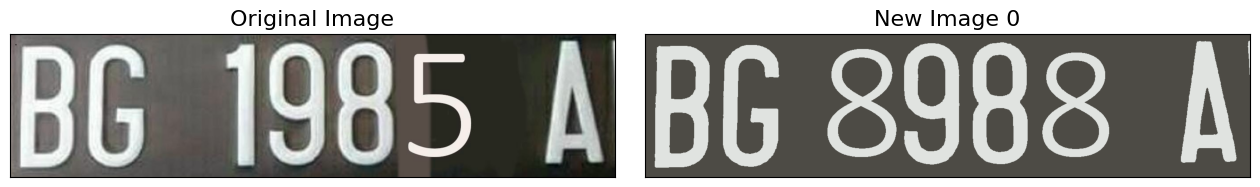

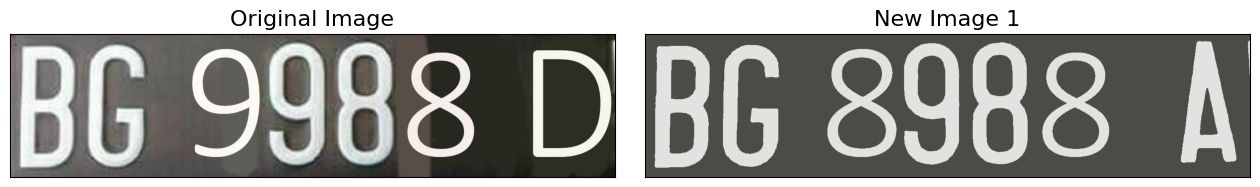

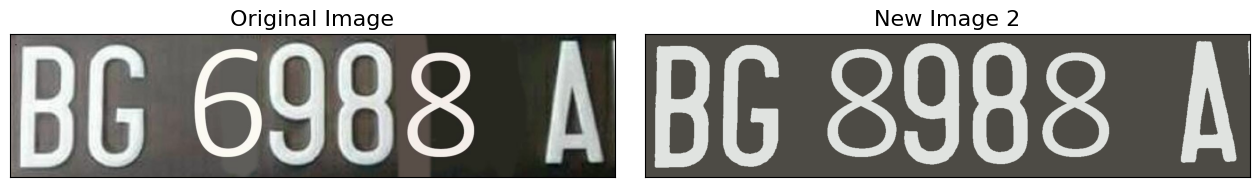

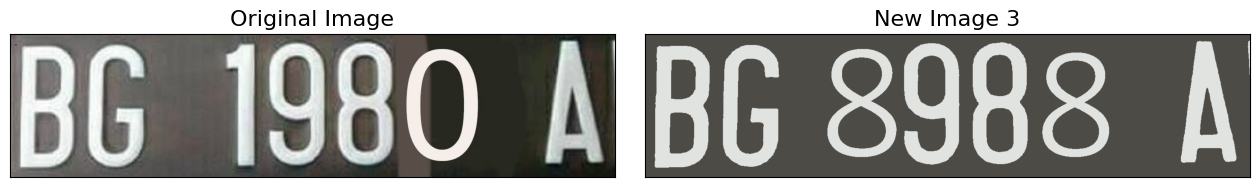

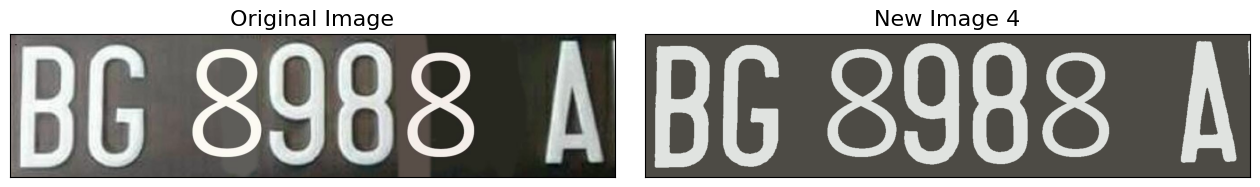

In [49]:
for i,image_file in enumerate(image_files):
  segmented_image = cluster_image_kmeans(image_file)
  compare_image(image_file, segmented_image, title_2 = f"New Image {i}")

In [ ]:
!sudo apt-get install tesseract-ocr
!pip install pytesseract
!pip install tesseract
!pip install tesseract-ocr

In [57]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pytesseract
from sklearn.cluster import MiniBatchKMeans

# Fungsi untuk mengubah warna gambar
def change_color(image):
    h, w, ch = image.shape
    data = image.astype(np.float32) / 255.0
    data = data.reshape(h * w, ch)

    kmeans = MiniBatchKMeans(2)
    kmeans.fit(data)
    new_colors = kmeans.cluster_centers_[kmeans.predict(data)]
    recolored = (new_colors.reshape(h, w, ch) * 255).astype(np.uint8)

    return recolored

# Fungsi untuk meningkatkan kejelasan nomor plat dengan logika if
def enhance_plate(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

    if np.mean(thresh) > 128:  # Logika if untuk memastikan bahwa angka menjadi putih dan background menjadi hitam
        thresh = cv2.bitwise_not(thresh)

    return thresh

# Fungsi untuk menghilangkan noise dengan ukuran kernel yang disesuaikan
def remove_noise(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size)

# Fungsi untuk melakukan inversi warna
def invert_colors(image):
    return cv2.bitwise_not(image)

# Fungsi untuk mengekstraksi teks dari gambar menggunakan pytesseract
def extract_text(image):
    return pytesseract.image_to_string(image)

def get_text(image_file):
  recolored = change_color(image_file)
  denoised_image = remove_noise(recolored, kernel_size=9)
  enhanced_plate = enhance_plate(denoised_image)
  inverted_plate = invert_colors(enhanced_plate)
  extracted_text = extract_text(inverted_plate)
  print(f"Hasil ekstraksi teks dari file ke - {i}: {extracted_text}")

  # Menampilkan gambar asli, gambar dengan warna diubah, hasil setelah menghilangkan noise, dan hasil akhir setelah meningkatkan kejelasan nomor plat
  fig, ax = plt.subplots(1, 5, figsize=(20, 6), subplot_kw=dict(xticks=[], yticks=[]))
  fig.subplots_adjust(wspace=0.05)
  ax[0].imshow(cv2.cvtColor(image_file, cv2.COLOR_BGR2RGB))
  ax[0].set_title('Original Image', size=16)
  ax[1].imshow(cv2.cvtColor(recolored, cv2.COLOR_BGR2RGB))
  ax[1].set_title('2-color Image', size=16)
  ax[2].imshow(cv2.cvtColor(denoised_image, cv2.COLOR_BGR2RGB))
  ax[2].set_title('Denoised Image', size=16)
  ax[3].imshow(enhanced_plate, cmap='gray')
  ax[3].set_title('Enhanced Plate', size=16)
  ax[4].imshow(inverted_plate, cmap='gray')
  ax[4].set_title('Inverted Plate', size=16)
  plt.show()
  print(f"Hasil ekstraksi teks dari file ke - {i}: {extracted_text}")



Hasil ekstraksi teks dari file ke - 0:  



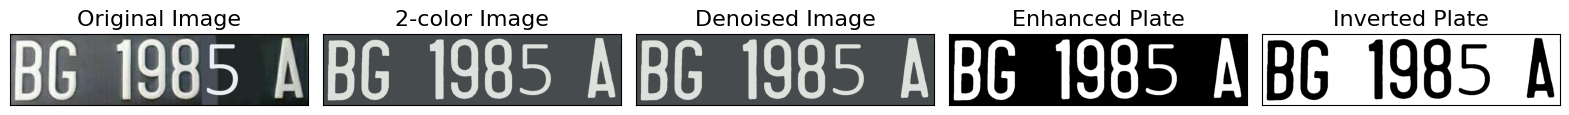

Hasil ekstraksi teks dari file ke - 0:  

Hasil ekstraksi teks dari file ke - 1: 


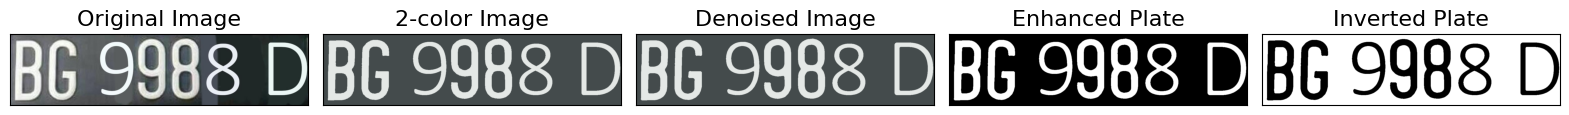

Hasil ekstraksi teks dari file ke - 1: 
Hasil ekstraksi teks dari file ke - 2:  



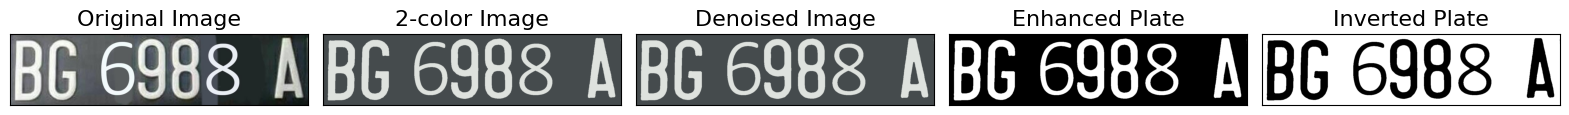

Hasil ekstraksi teks dari file ke - 2:  

Hasil ekstraksi teks dari file ke - 3:  



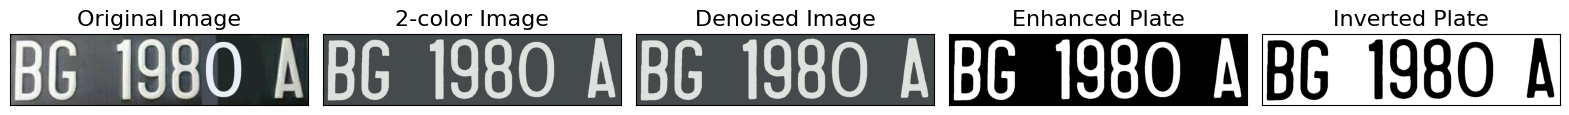

Hasil ekstraksi teks dari file ke - 3:  

Hasil ekstraksi teks dari file ke - 4:  



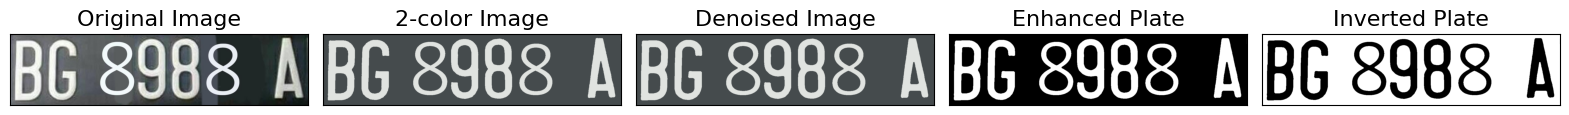

Hasil ekstraksi teks dari file ke - 4:  



In [58]:
# Mengubah warna, menghilangkan noise, dan meningkatkan kejelasan nomor plat untuk setiap gambar dalam folder
for i, image_file in enumerate(image_files):
  get_text(image_file)


In [59]:
extract_text(image_files[0])

' \n\x0c'